# TLDI2: Tea Leave Disease Identifier 2

```
git@github.com:fziilk/tldi2_release.git
```

## Importing Dependencies

In [12]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
try:
    # loading model
    import keras
    import tensorflow as tf
    
    # basic utilities
    from zipfile import ZipFile
    import numpy as np
    import os
    import shutil
    import splitfolders

    # evaluation
    from sklearn.metrics import classification_report

    print(f"using tensorflow v{tf.__version__}")
    print(f"using keras v{keras.__version__}")
except Exception:
    import sys
    exc_type, exc_obj, exc_tb = sys.exc_info()
    raise Exception(f"error on importing dependencies! Error on line: {exc_tb.tb_lineno}")
finally:
    print(f"Success on importing dependencies!")

using tensorflow v2.9.2
using keras v2.9.0
Success on importing dependencies!


## Demo

In [2]:
CLASS_MAPPING = ["algal_leaf", "anthracnose", "bird_eye_spot", "brown_blight", "gray_light", "healthy", "red_leaf_spot", "white_spot"]

In [28]:
class tldi():
    def load(model_path: str):
        """
        Params
        ------
        model_path (str): path to saved model {if using saved_model format, model_path is the parent directory of the saved model}
        """

        if model_path.split(".")[-1] == "h5":
            model = keras.models.load_model(model_path)
        else:
            model = tf.saved_model.load(model_path)

        return model

    def predict(model, img_path, class_mapping, display_img=True, raw_pred=False):
        image = keras.utils.load_img(img_path, target_size=(224, 224))

        # exceptional for deploying model
        if display_img:
            import matplotlib.pyplot as plt

            plt.figure()
            plt.imshow(image)
            plt.colorbar()
            plt.grid(False)
            plt.show()

        image = keras.utils.img_to_array(image)
        image = np.expand_dims(image, axis=0)

        y_hat = model.predict(np.vstack([image]))

        if raw_pred:
            print(f"prediction: {y_hat}")

        class_index = np.argmax(y_hat)
        y_hat_class = class_mapping[class_index]
        
        return y_hat_class, class_index

In [5]:
class utils:
    def kaggle(token_path: str, datasets=None, copy=True):
        root_dir = "/root/.kaggle"
        file_name = "kaggle.json"
        file_loc = os.path.join(root_dir, file_name)

        if not os.path.isdir(root_dir):
            os.mkdir(root_dir)

        if copy:
            shutil.copy(token_path, root_dir)
            status = "copied"
        else:
            shutil.move(token_path, root_dir)
            status = "moved"

        os.chmod(file_loc, 600)
        print(f"'kaggle.json' file have been {status} to {file_loc}!")

        if datasets is not None:
            from kaggle.api.kaggle_api_extended import KaggleApi

            api = KaggleApi()
            api.authenticate()

            if type(datasets) == str:
                datasets = [datasets]

            for dataset in datasets:
                api.dataset_download_cli(dataset)

            print(f"\nDataset has been successfully downloaded!")

    def unzip(path: str, output_dir: str, del_src=False):
        with ZipFile(path, "r") as zf:
            zf.extractall(output_dir)

        print(f"'{path}' has been extracted!")

        if del_src:
            os.remove(path)

### Getting the Models

In [24]:
!git clone --branch models https://github.com/fziilk/tldi2_release.git

Cloning into 'tldi2_release'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.


#### Loading the Models

In [25]:
base = os.path.join(os.getcwd(), "tldi2_release")

In [26]:
# tldi2_g2 h5 format
tldi_g2_1 = tldi.load(os.path.join(base, "tldi2_g2.h5"))

# tldi2_g2 saved_model.pb format
tldi_g2_2 = tldi.load(os.path.join(base, "tldi2v1_g2"))

# tldi2_resnet50 h5 format
tldi_resnet50 = tldi.load(os.path.join(base, "tldi2_resnet50.h5"))

### Getting Input Data

In [10]:
def normalize_dir(parent_dir: str):
    for dir_name in os.listdir(parent_dir):
        new_dir_name = dir_name.replace(" ", "_")
        new_dir_name = new_dir_name.lower()

        os.rename(os.path.join(parent_dir, dir_name), os.path.join(parent_dir, new_dir_name))

In [6]:
from google.colab import files

uploaded = files.upload()
file_path = os.path.join(os.getcwd(), list(uploaded.keys())[0])

Saving kaggle.json to kaggle.json


In [7]:
utils.kaggle(token_path=file_path,
             datasets="shashwatwork/identifying-disease-in-tea-leafs",
             copy=True)

'kaggle.json' file have been copied to /root/.kaggle/kaggle.json!


100%|██████████| 740M/740M [00:06<00:00, 128MB/s]



Dataset has been successfully downloaded!


In [8]:
utils.unzip(path="/content/identifying-disease-in-tea-leafs.zip", output_dir="/content")

'/content/identifying-disease-in-tea-leafs.zip' has been extracted!


In [9]:
dataset_base = "/content/dataset"
os.rename("/content/tea sickness dataset", dataset_base)

In [11]:
normalize_dir(dataset_base)

In [14]:
splitfolders.ratio(
    dataset_base,
    output="main_dataset",
    seed=2345, ratio=(.5, .0, .5),
    move=False
)

Copying files: 885 files [00:02, 359.91 files/s] 


In [15]:
dataset_base = "/content/main_dataset"

shutil.rmtree(os.path.join(dataset_base, "val"))

### Evaluation

In [16]:
TEST_PATH = os.path.join(dataset_base, "test")

In [ ]:
Y_HAT = list()
Y_TRUE = list()

for subdir in os.listdir(TEST_PATH):
    class_path = os.path.join(TEST_PATH, subdir)
    images = os.listdir(class_path)

    for image in images:
        image_path = os.path.join(class_path, image)

        y_hat, y_hat_i = tldi.predict(tldi_g2_1,
                             image_path,
                             CLASS_MAPPING,
                             display_img=False,
                             raw_pred=False)
        
        y_true_i = CLASS_MAPPING.index(subdir)

        print(y_hat)
        print(y_hat_i)

        print(y_true_i)
        print(subdir)

        Y_HAT.append(y_hat_i)
        Y_TRUE.append(y_true_i)

In [71]:
print(classification_report(Y_TRUE, Y_HAT, target_names=CLASS_MAPPING))

               precision    recall  f1-score   support

   algal_leaf       0.94      0.77      0.85        57
  anthracnose       0.63      0.84      0.72        50
bird_eye_spot       0.82      0.64      0.72        50
 brown_blight       0.85      0.93      0.89        57
   gray_light       0.84      0.74      0.79        50
      healthy       1.00      1.00      1.00        37
red_leaf_spot       1.00      0.82      0.90        72
   white_spot       0.69      0.86      0.76        71

     accuracy                           0.82       444
    macro avg       0.85      0.83      0.83       444
 weighted avg       0.84      0.82      0.82       444



### Getting a Prediction

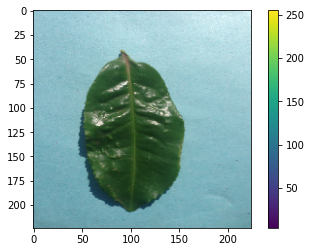

1/1 [==============================] - 0s 98ms/step
{'path': '/content/main_dataset/test/healthy/UNADJUSTEDNONRAW_thumb_209.jpg', 'y_true': 'healthy', 'y_hat': 'healthy'}


In [49]:
img = {"path": "/content/main_dataset/test/healthy/UNADJUSTEDNONRAW_thumb_209.jpg",
       "y_true": "healthy"}


y_hat, i = tldi.predict(tldi_g2_1, img["path"], CLASS_MAPPING)
img["y_hat"] = y_hat

print(img)